# TODO

- lineage? YES --> spin up polymorphism scoring from BAMs (pretty complex problem)
- SCPs require contact with nerves: 
https://www.cell.com/cell/fulltext/S0092-8674(09)01043-5?_returnURL=https%3A%2F%2Flinkinghub.elsevier.com%2Fretrieve%2Fpii%2FS0092867409010435%3Fshowall%3Dtrue
- find marker genes of hair follicle melanocytes

CREATE JUP NOTEBOOK AND SHARE


May 27 - Apr 3

ADD IMAGES TO DRIVE FOLDER
    - emailed on May 30
    
2) Would it make sense/be possible to redo the correlation tests but instead of comparing the whole transcriptome profile of the direct and indirect melanocytes, only compare based on a subsetted gene list of what genes are enriched in each pathway or the genes that are driving the first principal component or something like that? Would that give a better picture of "this is what is unique about the indirect melanocytes compared to the direct melanocytes, and these factors that make the indirect melanocytes unique are more correlated to primary/cancer"
    - correlations using only marker genes does not change correlations


May 20-26

1) When looking at the correlations of each cell type to the melanoma lines, would it be possible to get the gene lists for what is driving the correlation that is there so that we can identify the genes present in the indirect melanocytes that make them more correlated than the direct melanocytes?
    - implemented 3-way linear regression and analysis of residuals
    - can now prioritize genes on both dir vs indir and dish vs cancer
    - linear model poorly describes the expression correlation between dish MELs and cancer

3) For the heat maps (in the first two slides of what you sent) add glial genes (CD44, S100B, CAV1, PMP22, MBP) this might help with showing that the "bi-potent progenitor" isn't just this weird almost melanocyte thing but more of a weird in-between melanocyte/glia thing, while also showing that these glial genes are never present in the direct lineage.
    - implemented new genes
    - looks like most marker genes look like melanoblasty


# Setup

In [1]:
wkdir, s3dir = '/home/ubuntu/data/DL20190312_dish_mel', 'daniel.le-work/dish_MEL'
%reload_ext autoreload
%autoreload 2
from scanpy_helpers_1 import *
from scanpy_helpers_2 import *
print ('scanpy version: {}'.format(sc.__version__))
warnings.filterwarnings('ignore')
%matplotlib inline
import gc
from collections import defaultdict
import multiprocessing, glob
from sklearn.preprocessing import scale, MinMaxScaler
sc.settings.figdir = '/home/ubuntu/data/DL20190312_dish_mel/plot/'


# import data from s3
for file in ['adata_all','adata_coi']:
# for file in ['adata_unproc', 'COI_names']:
        
#     ! aws s3 cp s3://{s3dir}/{file}.p {wkdir}/
    var = pickle.load((open(f'{wkdir}/{file}.p', 'rb')))
    exec(f'{file} = var')
    del var
    gc.collect()


/home/ubuntu/anaconda3/lib/python3.7/site-packages/scanpy/api/__init__.py:6: FutureWarning: 

In a future version of Scanpy, `scanpy.api` will be removed.
Simply use `import scanpy as sc` and `import scanpy.external as sce` instead.

  FutureWarning


scanpy version: 1.4.4.post1


In [2]:
# FUNCTIONS
def min_max_scaler(x):
    scaler = MinMaxScaler()
    scaler.fit(x.reshape((-1,1)))
    return scaler.transform(x.reshape((-1,1))).reshape((-1,))

def single_mwu(args):    
    # inputs
    gene_val, df1, df2, alt = args
    
    try:
        stat, pval = stats.mannwhitneyu(df1[gene_val].values,
                                        df2[gene_val].values, 
                                        alternative = alt
                                       )
    except:
        stat = np.nan
        pval = np.nan
    return (stat, pval)

def parallel_mwu(genes, df1, df2, method='two-sided', ncores=1):
    
    p = multiprocessing.Pool(processes=ncores)
    try:
        mwu_tuples = p.map(single_mwu, 
                                zip(genes,
                                    [df1]*len(genes),
                                    [df2]*len(genes),
                                    [method]*len(genes)
                                   ), 
                                chunksize=100)
    finally:
        p.close()
        p.join()

    stat_list = [x[0] for x in mwu_tuples]
    pval_list = [x[1] for x in mwu_tuples]
    return (stat_list, pval_list)

def disp_analysis(adata, min_mean=None, max_mean=None, min_disp=None):
    
    print('Process expression data...')
    print('\tInitial:')
    sum_output(adata)
    
    tmp = sc.pp.normalize_per_cell(adata, copy=True)
    filter_result = sc.pp.filter_genes_dispersion(tmp.X, 
                                                  min_mean=min_mean, 
                                                  max_mean=max_mean, 
                                                  min_disp=min_disp)
    tmp = tmp[:, filter_result.gene_subset]
    
    print('Filtered cells: {}'.format(len(adata.obs) - len(tmp.obs)))
    print('Filtered genes: {}'.format(len(adata.var_names) - len(tmp.var_names)))
    print('\tResult:')
    sum_output (tmp)
    
    return tmp

## Ingest data

In [3]:
run_me = False

if run_me == True:

    raw_dir = '/home/ubuntu/data/DL20190312_dish_mel/raw_dish_allcells'
    out_dir = '/home/ubuntu/data/DL20190312_dish_mel/'
    for idx, subdir in enumerate(glob.glob(f'{raw_dir}/*/')):
        # extract metadata
        meta_str = subdir.split('/')[-2].split('_')
        path = meta_str[0]
        if path == 'dir':
            path = 'direct'
        elif path == 'indir':
            path = 'indirect'
        day = int(meta_str[1][1:])

        print(path, day)

        # compile expression data
        adata_slice = sc.read_10x_mtx(subdir)
        sc.pp.filter_cells(adata_slice, min_genes=500)
        sc.pp.filter_cells(adata_slice, min_counts = 1000)
        adata_slice.obs['path'] = path
        adata_slice.obs['day'] = day

        if idx == 0:
            adata_all = adata_slice 
        else:
            adata_all = adata_all.concatenate(adata_slice, join='outer')

    # remove ERCC counts
    adata_all = adata_all[:, [x for x in adata_all.var_names if not x.startswith('ERCC-')]]

    # update categorical path
    adata_all.obs['path'] = (adata_all
                             .obs['path']
                             .astype(str)
                             .astype(CategoricalDtype(['indirect','direct','trunk']))
                            )

    # log transform
    adata_all.raw = sc.pp.log1p(adata_all, copy=True) # freeze raw state

    # pickle adatas
    for objname in ['adata_all']:
        pickle.dump(eval(objname), open( f'{out_dir}/{objname}.p', 'wb' ), protocol=4)
        syscmd = f'aws s3 cp {wkdir}/{objname}.p s3://{s3dir}/'
        subprocess.run(syscmd.split(' '))


In [4]:
# pca and umap optimization
run_me = False
if run_me == True:
    n_pcs = 75

    all_cells_adata = sc.pp.log1p(adata_all, copy=True) # new
    sc.pp.highly_variable_genes(all_cells_adata,min_mean=0.1,max_mean=10,min_disp=0.5) # new
    sc.pp.scale(all_cells_adata) # new
    sc.tl.pca(all_cells_adata, 
              use_highly_variable = True, 
              n_comps=n_pcs, 
              random_state=1,
              svd_solver='arpack',
              zero_center=False
             ) # new
    sc.pp.neighbors(all_cells_adata, n_pcs=n_pcs, n_neighbors = 15, random_state=1) # new
    sc.tl.umap(all_cells_adata, min_dist = 0.5, random_state=1)
    sc.tl.louvain(all_cells_adata, resolution = 1, random_state=1)

    sc.pl.umap(all_cells_adata, color = ['louvain','day','path'], legend_loc = 'on data', 
                   palette = 'tab20', cmap = 'nipy_spectral', )
    #            save = 'plot_1.svg')


## Module scoring for annotations


In [7]:
run_me = False

if run_me == True:
    input_adata = all_cells_adata

    cycling_module = ['TOP2A','CDK1','UBE2C',
                      'HIST1H4E','HIST1H4C'] # ref: https://www.biorxiv.org/content/biorxiv/early/2019/02/03/526848.full.pdf
    CNS_neuronal_precursors = ['SIX3','PAX6','FEZF1',
                               'DLK1','HESX1','LHX5',
                               'LMO1','EMX2','ARX']
    ESC = ['DNMT3B','NANOG','POU5F1','SOX2']
    low_quality = ['ACTB','GAPDH','RPL7','RPS27A']
    neural_crest_precursors = ['SOX10','FOXD3','WNT1',
                               'SNAI2','SOX9','PAX3']
    ectoderm_fibroblast = ['GATA3','EPCAM','KRT18',
                           'KRT19','CD9','CLDN6']
    trigeminal_placode_ganglia = ['SST','ISL1','SIX1',
                                  'POU4F1','NEFM']
    cranial_placode = ['PAX6','BMP4','RBFOX1','CD82']
    CNS_precursors = ['FRZB','NEFM','MSX1','MSX2','CDH11']
    schwann = ['TGFB1','GDNF','CDH19','TGFBR2','MPZ','GAP43']

    genesOI = list(set(cycling_module + CNS_neuronal_precursors + ESC + low_quality + neural_crest_precursors +
                                    ectoderm_fibroblast + trigeminal_placode_ganglia + cranial_placode + CNS_precursors + schwann))
    print('missing genes:', [x for x in genesOI if x not in input_adata.var_names])

    input_adata.obs['cell'] = input_adata.obs.index.tolist()
    input_adata.obs['cell'] = (input_adata
                              .obs['cell']
                              .astype(str)
                              .astype(CategoricalDtype(input_adata.obs['cell'].tolist())))
    cat, exp_df = prepare_dataframe(input_adata,
                     var_names = genesOI,
                     groupby = 'cell')
    exp_df = exp_df.rank(pct=True, axis=0, method = 'min') # ranked expression per cell
    exp_df = exp_df.rank(pct=True, axis=1, method = 'min') # ranking ranked expression per gene
    input_adata.obs['cycling_score'] = exp_df.loc[:,cycling_module].mean(axis=1)
    input_adata.obs['CNS_neuronal_precursors'] = exp_df.loc[:,CNS_neuronal_precursors].mean(axis=1)
    input_adata.obs['ESC'] = exp_df.loc[:,ESC].mean(axis=1)
    input_adata.obs['low_quality'] = exp_df.loc[:,low_quality].mean(axis=1)
    input_adata.obs['neural_crest_precursors'] = exp_df.loc[:,neural_crest_precursors].mean(axis=1)
    input_adata.obs['ectoderm_fibroblast'] = exp_df.loc[:,ectoderm_fibroblast].mean(axis=1)
    input_adata.obs['trigeminal_placode_ganglia'] = exp_df.loc[:,trigeminal_placode_ganglia].mean(axis=1)
    input_adata.obs['cranial_placode'] = exp_df.loc[:,cranial_placode].mean(axis=1)
    input_adata.obs['CNS_precursors'] = exp_df.loc[:,CNS_precursors].mean(axis=1)
    input_adata.obs['schwann'] = exp_df.loc[:,schwann].mean(axis=1)
    
    targets = ['cycling_score', 'CNS_neuronal_precursors', 'ESC', 
               'low_quality','neural_crest_precursors','ectoderm_fibroblast',
               'trigeminal_placode_ganglia', 'cranial_placode', 'CNS_precursors','schwann'
              ]
    
#     clusters
    sc.pl.umap(input_adata, color = ['louvain','day','path'], legend_loc = 'on data', 
               palette = 'tab20', cmap = 'nipy_spectral', )
#            save = 'plot_2.svg')
    
#     module scores
    sc.pl.umap(input_adata, color = targets, cmap = 'nipy_spectral', ncols = 2, )
#            save = 'plot_3.svg')
    
#     quality metrics
    sc.pl.umap(input_adata, color = ['n_counts','n_genes'], 
               cmap = 'nipy_spectral', ncols = 2,)
#               save = 'plot_4.svg')


In [8]:
run_me = False
save_results = False

if run_me == True: 
    input_adata = all_cells_adata

    # manual annotations

    ## create dictionary
    cluster2anno = {'3':'ESC_COI', # ESC
                    '2':'neural_crest_precursors_COI', # neural crest
                    '11':'trigeminal_placode_ganglia', # indir_d15
                    '21':'ectoderm_fibroblast',
                    '13':'cranial_placode', # indir_d22
                    '5':'indir_branchpoint_COI', # indir_d15-30
                    '15':'indir_branchpoint_COI',
                    '17':'indir_branchpoint_COI',
                    '23':'indir_branchpoint_COI',
                    '4':'indir_d41_COI', # indir_d41
                    '20':'indir_d41_COI', # indir_d41
                    '0':'indir_d50_59_COI', # indir_d50-59
                    '6':'indir_d50_59_COI',
                    '9':'dir_branchpoint_COI', # dir_d15
                    '18':'dir_d22_COI', # dir_d22
                    '10':'dir_d22_COI', # dir_d22
                    '14':'dir_d22_COI', # dir_d22
                    '1':'dir_d30_COI', # dir_d30
                    '16':'dir_d30_COI',
                   }

    ### update dict with unknown cluster label
    for x in [x for x in set(input_adata.obs.louvain) if x not in [key for key,value in cluster2anno.items()]]:
        cluster2anno[x] = f'low_quality_{x}'

    input_adata.obs['annotation'] = input_adata.obs['louvain'].map(cluster2anno)
    sc.pl.umap(input_adata, color = ['annotation'], palette = 'tab20',)
#               save = 'plot_5.svg')

    ## add COI bool label
    input_adata.obs['COI'] = [x.endswith('_COI') for x in input_adata.obs['annotation']]
    input_adata.obs['COI'] = input_adata.obs['COI'].astype(str)
    sc.pl.umap(input_adata, color = ['COI','day','path','louvain'], palette = 'tab20', ncols =2,)
#               save = 'plot_6.svg')

    ## save and push
    adata_coi = input_adata[input_adata.obs.COI == 'True']
    COI_names = adata_coi.obs_names.values.tolist()
    
    # pickle adatas
    if save_results == True:
        
        for objname in ['COI_names']:
            pickle.dump(eval(objname), open( f"{wkdir}/{objname}.p", "wb" ), protocol=4 )
            syscmd = f'aws s3 cp {wkdir}/{objname}.p s3://{s3dir}/'
            subprocess.run(syscmd.split(' '))
    

# subet to COI

In [9]:
run_me = False
if run_me == True:  
    input_adata = all_cells_adata
    coi_idx = input_adata[input_adata.obs['COI'] == 'True'].obs.index.tolist()
    # UMAP and PCA
    # pca and umap optimization
    n_pcs = 150
    adata_coi = sc.pp.log1p(adata_all[[x in coi_idx for x in adata_all.obs.index]], copy=True) # new
    sc.pp.highly_variable_genes(adata_coi,min_mean=0.1,max_mean=10,min_disp=0.5) # new
    sc.pp.scale(adata_coi) # new
    sc.tl.pca(adata_coi, 
              use_highly_variable = True, 
              n_comps=n_pcs, 
              random_state=1,
              svd_solver='arpack',
              zero_center=False
             ) # new
    sc.pp.neighbors(adata_coi, n_pcs=n_pcs, n_neighbors = 20, random_state=1) # new
    sc.tl.umap(adata_coi, min_dist = 0.5, random_state=1)
    sc.tl.louvain(adata_coi, resolution = 1.7, random_state=1)
    sc.pl.umap(adata_coi, color = ['louvain','day','path'], legend_loc = 'on data', 
                   palette = 'tab20', cmap = 'nipy_spectral',)
# save = 'plot_7.svg')


In [10]:
run_me = False
if run_me == True:
    # high resolution
    schwann = ['TGFB1','GDNF','CDH19','TGFBR2','MPZ','GAP43']
    cat, exp_df = prepare_dataframe(adata_coi,
                         var_names = schwann,
                         groupby = 'louvain')

    adata_coi.obs['schwann'] = exp_df.loc[:,schwann].mean(axis=1).values
    sc.pl.umap(adata_coi, color = ['louvain','day','path','schwann'], legend_loc = 'on data', 
                   palette = 'tab20', cmap = 'nipy_spectral',)

In [11]:
run_me = False
if run_me == True:
    # add annotations
    input_adata = adata_coi
    cluster_labels = {'7':'indir_mel',
                      '8':'indir_mel',
                      '12':'indir_mel',
                      '15':'indir_mel',
                      '16':'indir_mel',
                      '4':'neural_crest',
                      '9':'neural_crest',
                      '18':'neural_crest',
                      '22':'neural_crest',
                      '21':'Schwann',
                      '23':'pre_mel_blast',
                      '1':'dir_mel',
                      '6':'dir_mel',
                      '5':'mel_blast',
                      '11':'mel_blast',
                      '14':'mel_blast',
                      '2':'pre_mel_blast',
                      '17':'pre_mel_blast',
                      '0':'pre_neural_crest',
                      '20':'pre_neural_crest',
                      '3':'emb_stem',
                      '19':'emb_stem',
                      '10':'pre_mel_glial',
                      '13':'pre_mel_glial',
                     }
    input_adata.obs['annotation'] = input_adata.obs['louvain'].map(cluster_labels)
    input_adata = input_adata[input_adata.obs['annotation'] != '-']
    input_adata.obs['annotation'] = (input_adata.obs['annotation']
                                        .astype(str)
                                        .astype(CategoricalDtype(['emb_stem', 
                                                                  'pre_neural_crest',
                                                                  'neural_crest',
                                                                  'pre_mel_glial',
                                                                  'Schwann',
                                                                  'pre_mel_blast',
                                                                  'mel_blast',
                                                                  'indir_mel',
                                                                  'dir_mel',
                                                                 ],ordered=True)))

    sc.pl.umap(input_adata, color = ['louvain','annotation'], 
               legend_loc = 'on data', )
    # save = 'plot_8.svg')


# cycling score

In [12]:
run_me = False
if run_me == True:
    cycling_module = ['TOP2A','CDK1','UBE2C','CDT1']
    input_adata = adata_coi
    threshold = 60

    input_adata.obs['cell'] = input_adata.obs.index.tolist()
    input_adata.obs['cell'] = (input_adata
                              .obs['cell']
                              .astype(str)
                              .astype(CategoricalDtype(input_adata.obs['cell'].tolist())))
    cat, exp_df = prepare_dataframe(input_adata,
                     var_names = cycling_module,
                     groupby = 'cell')
    exp_df = exp_df.rank(pct=True, axis=0, method = 'min') # ranked expression per cell
    exp_df = exp_df.rank(pct=True, axis=1, method = 'min') # ranking ranked expression per gene

    input_adata.obs['cycling_score'] = exp_df.loc[:,cycling_module].mean(axis=1)
    omit_names = (input_adata[input_adata.obs.cycling_score > np.percentile(input_adata.obs.cycling_score.values, 
                                                                            threshold)]
                  .obs
                  .index
                  .tolist()
                 )

    input_adata.obs['cycling_cell'] = ['G2_M' if x in set(omit_names) else \
                                       'G1_S' for x in input_adata.obs.index]

    sc.pl.umap(input_adata, color = ['cycling_score','cycling_cell'])


In [50]:
# for objname in ['adata_coi']:
#     pickle.dump(eval(objname), open( f"{wkdir}/{objname}.p", "wb" ), protocol=4 )
#     syscmd = f'aws s3 cp {wkdir}/{objname}.p s3://{s3dir}/'
#     subprocess.run(syscmd.split(' '))

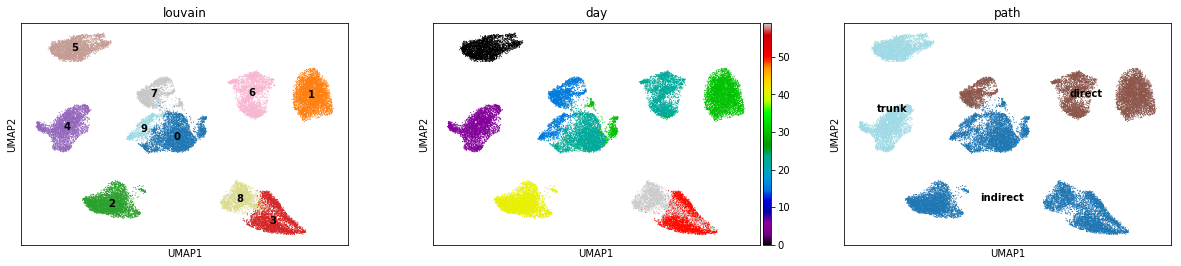

In [13]:
run_me = True
input_adata = adata_coi
coi_idx = input_adata[input_adata.obs['cycling_cell'] == 'G1_S'].obs.index.tolist()

if run_me == True:    
    # UMAP and PCA
    # pca and umap optimization
    n_pcs = 150
    adata_coi_noncyc = sc.pp.log1p(adata_all[[x in coi_idx for x in adata_all.obs.index]], copy=True) # new
    sc.pp.highly_variable_genes(adata_coi_noncyc,min_mean=0.1,max_mean=10,min_disp=0.5) # new
    sc.pp.scale(adata_coi_noncyc) # new
    sc.tl.pca(adata_coi_noncyc, 
              use_highly_variable = True, 
              n_comps=n_pcs, 
              random_state=1,
              svd_solver='arpack',
              zero_center=False
             ) # new
    sc.pp.neighbors(adata_coi_noncyc, n_pcs=n_pcs, n_neighbors = 25, random_state=1) # new
    sc.tl.umap(adata_coi_noncyc, min_dist = 0.5, random_state=1)
    sc.tl.louvain(adata_coi_noncyc, resolution = 0.5, random_state=1)
    sc.pl.umap(adata_coi_noncyc, color = ['louvain','day','path'], legend_loc = 'on data', 
                   palette = 'tab20', cmap = 'nipy_spectral',)


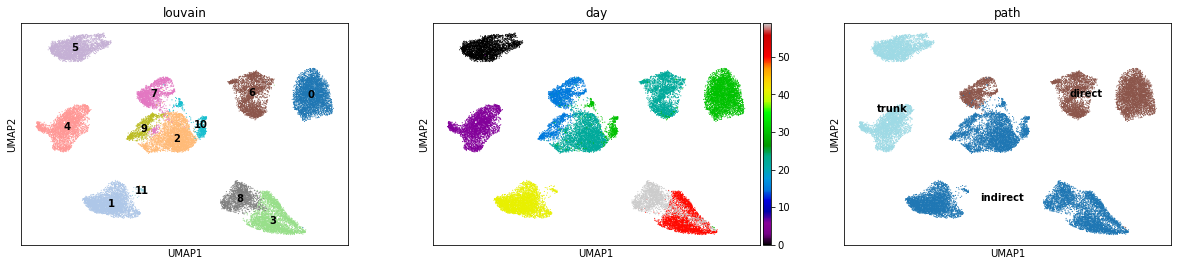

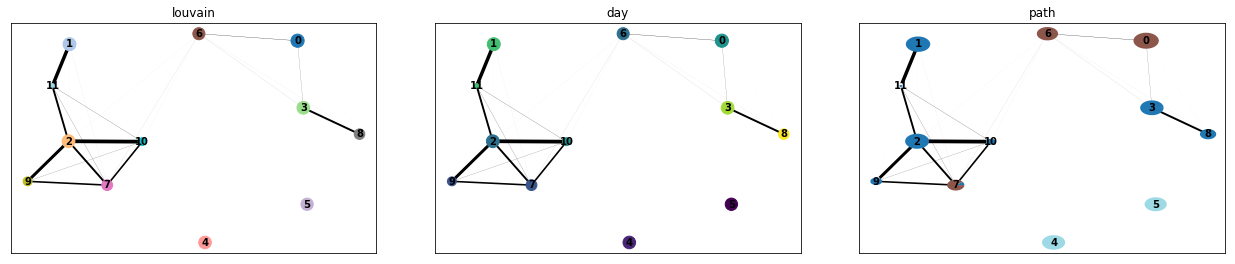

In [14]:
sc.tl.louvain(adata_coi_noncyc, resolution = 1, random_state=1)
sc.pl.umap(adata_coi_noncyc, color = ['louvain','day','path'], legend_loc = 'on data', 
               palette = 'tab20', cmap = 'nipy_spectral',)
sc.tl.paga(adata_coi_noncyc, groups='louvain')
sc.pl.paga(adata_coi_noncyc, color=['louvain','day','path'],
          threshold=0)
# sc.tl.umap(adata_coi_noncyc, min_dist = 0.5, 
#            random_state=1, init_pos='paga')
# sc.pl.umap(adata_coi_noncyc, color = ['louvain','day','path'], legend_loc = 'on data', 
#                palette = 'tab20', cmap = 'nipy_spectral',)


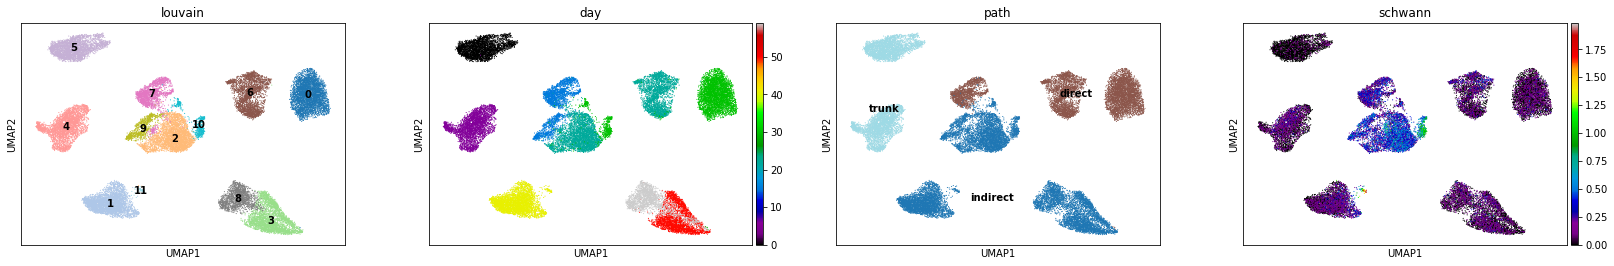

In [49]:
# final resolution
sc.tl.louvain(adata_coi_noncyc, resolution = 1, random_state=1)

schwann = ['TGFB1','GDNF','CDH19','TGFBR2','MPZ','GAP43']
cat, exp_df = prepare_dataframe(adata_coi_noncyc,
                     var_names = schwann,
                     groupby = 'louvain')

adata_coi_noncyc.obs['schwann'] = exp_df.loc[:,schwann].mean(axis=1).values
sc.pl.umap(adata_coi_noncyc, color = ['louvain','day','path','schwann'], legend_loc = 'on data', 
               palette = 'tab20', cmap = 'nipy_spectral',)


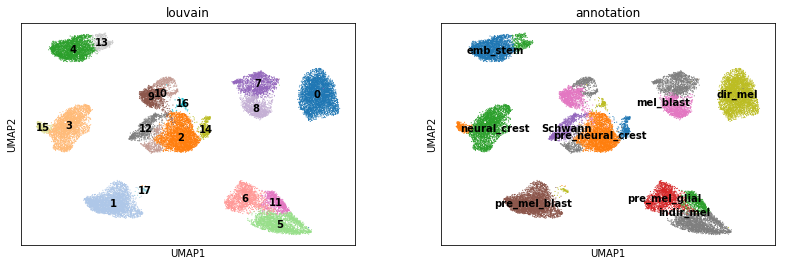

In [48]:
# add annotations
input_adata = adata_coi_noncyc
cluster_labels = {'0':'dir_mel',
                  '1':'pre_mel_blast',
                  '17':'pre_mel_blast',
                  '2':'pre_neural_crest',
                  '3':'neural_crest',
                  '4':'emb_stem',
                  '5':'indir_mel',
                  '6':'pre_mel_glial',
                  '7':'indir_mel',
                  '8':'mel_blast',
                  '9':'mel_blast',
                  '10':'indir_mel',
                  '11':'neural_crest',
                  '12':'Schwann',
                  '13':'neural_crest',
                  '14':'emb_stem',
                  '15':'pre_neural_crest',
                 }
input_adata.obs['annotation'] = input_adata.obs['louvain'].map(cluster_labels)
input_adata.obs['annotation'] = (input_adata.obs['annotation']
                                    .astype(str)
                                    .astype(CategoricalDtype(['emb_stem', 
                                                              'pre_neural_crest',
                                                              'neural_crest',
                                                              'pre_mel_glial',
                                                              'Schwann',
                                                              'pre_mel_blast',
                                                              'mel_blast',
                                                              'indir_mel',
                                                              'dir_mel',
                                                             ],ordered=True)))

sc.pl.umap(input_adata, color = ['louvain','annotation'], 
           legend_loc = 'on data',)
# save = 'plot_8.svg')


In [ ]:
# for objname in ['adata_coi_noncyc']:
#     pickle.dump(eval(objname), open( f"{wkdir}/{objname}.p", "wb" ), protocol=4 )
#     syscmd = f'aws s3 cp {wkdir}/{objname}.p s3://{s3dir}/'
#     subprocess.run(syscmd.split(' '))

# PCA

In [ ]:
input_adata = adata_coi_noncyc
sc.pl.umap(input_adata, color = ['path', 'day','louvain'], palette = 'tab20', cmap = 'nipy_spectral')
components = ['1,2']

print('all_paths')
sc.pl.pca(input_adata, color = ['path'], components=components, palette = 'tab20', )
#           save = 'plot_9.svg')
print('trunk')
sc.pl.pca(input_adata[input_adata.obs.path == 'trunk'], color = ['day'], 
          components=components, cmap = 'nipy_spectral', )
#           save = 'plot_10.svg')
print('trunk + indirect')
sc.pl.pca(input_adata[input_adata.obs.path != 'direct'], color = ['day'], 
          components=components, cmap = 'nipy_spectral', )
#           save = 'plot_11.svg')
print('trunk + direct')
sc.pl.pca(input_adata[input_adata.obs.path != 'indirect'], color = ['day'], 
          components=components, cmap = 'nipy_spectral', )
#           save = 'plot_12.svg')


# Differential expression: path-specific terminally-differentiated

## Bulkized ranked correlation

In [ ]:
input_adata = adata_coi_noncyc
cat, adata_louvain_df = prepare_dataframe(input_adata,
                                          (input_adata.var['highly_variable'][input_adata.var['highly_variable'] == True]).index.tolist(),
                                          'annotation')

corr_df = (adata_louvain_df
           .reset_index()
           .groupby('annotation')
           .mean()
           .T)

plot_df = corr_df.corr('spearman')**2
plot_df.columns = plot_df.index.tolist()
plot_df['cluster'] = plot_df.index.tolist()
plot_df = pd.melt(plot_df, id_vars='cluster')
for i in ['cluster','variable']:
    plot_df[i] = (plot_df[i]
                        .astype(str)
                        .astype(CategoricalDtype(['emb_stem', 
                                                              'pre_neural_crest',
                                                              'neural_crest',
                                                              'pre_mel_glial',
                                                              'Schwann',
                                                              'pre_mel_blast',
                                                              'mel_blast',
                                                              'indir_mel',
                                                              'dir_mel',
                                                             ],
                                                 ordered=True)))
plot_df['label'] = [round(x,2) for x in plot_df.value]

plotnine.options.figure_size = (5,5)
p1 = (ggplot(plot_df)
      + theme_bw()
      + theme(axis_text_x = element_text(angle = 90))
      + geom_tile(aes('cluster','variable',fill='value'))
      + geom_text(aes('cluster','variable',label='label'), color = 'grey')
      + scale_fill_cmap('magma')
      + ggtitle('variance explained')
      + labs(x = '', y = ''))
print(p1)


In [ ]:
# p1.save('/home/ubuntu/data/DL20190312_dish_mel/plot/plot_13.svg', height=8, width=8)

## Analysis of marker genes over developmental time

In [ ]:
# on means
# ref: https://www.frontiersin.org/articles/10.3389/fnmol.2019.00069/full

input_adata = adata_coi_noncyc
genes = ['POU5F1','AXL','SOX2','NRG1','ALPL','WNT1','SOX9','PAX3',
         'NOTCH1','NCAM1','EGR2','NGFR','MPZ','GAP43',
         'CDH19','TGFBR2','GDNF',
         'ERBB3','SOX10','EDNRB','PMP22','CAV1',
         'TGFB1','KIT','S100B','CD44', 'MBP', 
         'MITF',
         'TRPM1','DCT','PMEL','MLANA','MC1R','OCA2','TYRP1','TYR']
direct_order = ['emb_stem', 
                  'pre_neural_crest',
                  'pre_mel_glial',
                  'mel_blast',
                  'dir_mel',
                 ]
indirect_order = ['emb_stem', 
                  'pre_neural_crest',
                  'neural_crest',
                  'Schwann',
                  'pre_mel_blast',
                  'indir_mel',
                 ]

for idx, grouping in enumerate(['direct', 'indirect']):
    order_list = eval(f'{grouping}_order')
        
    cat, df = prepare_dataframe(input_adata,
                                genes,
                                'annotation')
    df = df.apply(lambda x: min_max_scaler(x.values)) ### test
    df = df.reset_index()
    df['annotation'] = (df['annotation']
                                .astype(str)
                                .astype(CategoricalDtype(order_list,ordered=True)))
    plot_df = pd.melt(df
                       .groupby('annotation')
                       .mean()
                       .reset_index(), id_vars='annotation')
    plot_df['variable'] = (plot_df['variable']
                           .astype(str)
                           .astype(CategoricalDtype(genes, ordered=True))
                          )
    plot_df = plot_df.dropna()
    plotnine.options.figure_size = (4,4)
    p2 = (ggplot(plot_df)
          + theme_bw()
          + theme(axis_text_x = element_text(angle = 90))
          + geom_tile(aes('annotation','variable',fill = 'value'))
          + scale_fill_cmap('magma')
          + labs(x = "", y = "")
          + ggtitle(grouping)
         )
    print(p2)
#     p2.save(f'/home/ubuntu/data/DL20190312_dish_mel/plot/plot_{counter}.svg', height=8, width=8)


In [ ]:
# on single cells
# ref: https://www.frontiersin.org/articles/10.3389/fnmol.2019.00069/full

input_adata = adata_coi_noncyc
n_cells = 100

for idx, grouping in enumerate(['direct', 'indirect']):
    counter = idx + 16
    order_list = eval(f'{grouping}_order') 
        
    cat, df = prepare_dataframe(input_adata,
                                genes,
                                'annotation')
    df = df.apply(lambda x: min_max_scaler(x.values))
    df = df.reset_index()
    df['annotation'] = (df['annotation']
                                .astype(str)
                                .astype(CategoricalDtype(order_list,ordered=True)))
    df_melt = pd.melt((df
                       .groupby('annotation')
                       .apply(lambda x: (x.sample(n_cells)
                                         .assign(idx = lambda x: [i for i in range(len(x))])
                                        )
                             )
                      ), id_vars=['annotation','idx']
                     )
    df_melt['variable'] = (df_melt['variable']
                           .astype(str)
                           .astype(CategoricalDtype(genes, ordered=True))
                          )
    df_melt = df_melt.dropna()

    plotnine.options.figure_size = (6,6)
    p3 = (ggplot(df_melt)
          + theme_bw()
          + theme(axis_text_x = element_text(angle = 90),
                  strip_text_x = element_text(angle = 90, vjust=0),
                  strip_background = element_rect(fill = 'white', color = 'white')
                 )
          + geom_tile(aes('idx','variable',fill = 'value'))
          + scale_fill_cmap('magma')
          + labs(x = "", y = "")
          + facet_grid('.~annotation')
#           + ggtitle(grouping)
         )
    print(p3)
#     p3.save(f'/home/ubuntu/data/DL20190312_dish_mel/plot/{grouping}_plot_{counter}.svg', height=8, width=8)


## Analysis of cell type proportions over developmental time
INCLUDES CYCLING CELLS IN PROPORTION CALCULATION!!!

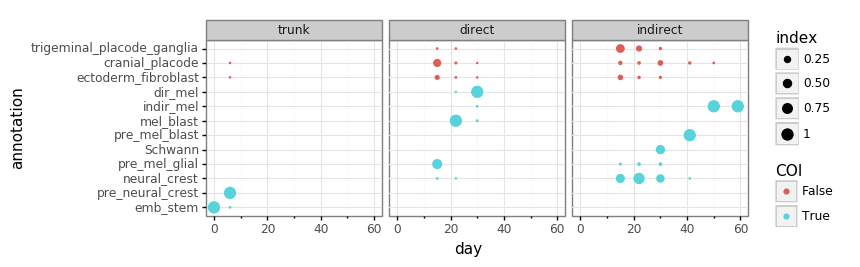

<ggplot: (8768771554792)>


In [157]:
adata_1 = (all_cells_adata[[not x.endswith('COI') for x in all_cells_adata.obs.annotation]]
           .obs
           .loc[:,['annotation','day','path']]
           .reset_index()
          )
adata_2 = (adata_coi
           .obs
           .loc[:,['annotation','day','path']]
           .reset_index()
          )
merge_adata = adata_1.append(adata_2)
merge_adata['annotation'] = [x if not x.startswith('low_') \
                             else 'low_qual'
                             for x in merge_adata['annotation']]
merge_adata = merge_adata.query('annotation != "low_qual"')
merge_adata = merge_adata.groupby(['path','day','annotation']).count().replace(np.nan,0)
merge_adata = merge_adata / merge_adata.groupby(['path','day']).sum()
merge_adata = (merge_adata
               .reset_index()
              )
merge_adata['annotation'] = (merge_adata['annotation']
                          .astype(str)
                          .astype(CategoricalDtype(['emb_stem', 
                                                  'pre_neural_crest',
                                                  'neural_crest',
                                                  'pre_mel_glial',
                                                  'Schwann',
                                                  'pre_mel_blast',
                                                  'mel_blast',
                                                  'indir_mel',
                                                  'dir_mel',
                                                    'ectoderm_fibroblast',
                                                    'cranial_placode',
                                                    'trigeminal_placode_ganglia',
                                                    'low_qual'
                                                   ],
                                                   ordered = True
                                                  ))
                         )
cois = ['emb_stem', 
          'pre_neural_crest',
          'neural_crest',
          'pre_mel_glial',
          'Schwann',
          'pre_mel_blast',
          'mel_blast',
          'indir_mel',
          'dir_mel',
       ]
merge_adata['COI'] = [x in cois for x in merge_adata['annotation']]
merge_adata['index'] = [np.nan if x == 0 else x for x in merge_adata['index']]
merge_adata['path'] = (merge_adata['path']
                       .astype(str)
                       .astype(CategoricalDtype(['trunk','direct','indirect'], ordered = True))
                      )

plotnine.options.figure_size = (7,7)
p4 = (ggplot(merge_adata)
      + theme_bw()
      + theme(aspect_ratio = 1)
      + geom_point(aes('day','annotation',size ='index',color='COI'))
      + xlim([0,60])
      + facet_wrap('~path')
      + scale_size_continuous(range=(0,4))
     )
print(p4)

# Cibersort

In [14]:
print(...)
# ingest existing processed files

## counts table
tcga_df_fltr = pd.read_csv('s3://daniel.le-work/MEL_project/tcga_skcm_counts.csv', index_col = 0)

## metadata
tcga_meta_ordered = pd.read_csv('s3://daniel.le-work/MEL_project/tcga_skcm_metadata.csv', index_col = 0)

stage2code = {'I/II NOS':np.nan,
             'Stage 0':0,
             'Stage I':1,
             'Stage IA':1,
             'Stage IB':1,
             'Stage II':2,
             'Stage IIA':2,
             'Stage IIB':2,
             'Stage IIC':2,
             'Stage III':3,
             'Stage IIIA':3,
             'Stage IIIB':3,
             'Stage IIIC':3,
             'Stage IV':4,
             '[Not Available]':np.nan}
tcga_meta_ordered['stage_code'] = [stage2code.get(x) for x in tcga_meta_ordered['ajcc_pathologic_tumor_stage']]


Ellipsis


In [20]:
input_adata = adata_coi_noncyc
groupby = 'annotation'
cell_n = 100
date_val = '20191202'
feature_set = [
              'indir_mel',
              'dir_mel',
]

genes_intersect = sorted(list((set(input_adata.var_names) & set(tcga_df_fltr.index))))
cat, df = prepare_dataframe(input_adata,
                                genes_intersect,
                                'louvain'
                             )
df[groupby] = input_adata.obs[groupby].values
df = df[[x in feature_set for x in df[groupby]]]
df['cell_id'] = [f'cell_{x}' for x in range(len(df))]
df = df.set_index('cell_id')
df = df.dropna()


In [21]:
# subsample
master_df = pd.DataFrame()
for x in set(df[groupby]):
    df_slice = df[df[groupby]==x]
    if len(df_slice) > cell_n:
        df_slice = df_slice.sample(frac=1).iloc[:cell_n,:]
    master_df = master_df.append(df_slice)

# pheno table
print('pheno table...')
pheno_df = pd.DataFrame(master_df.loc[:,groupby])
for x in set(df[groupby]):
    pheno_df[x] = [1 if name == x else 2 for name in pheno_df[groupby]]

pheno_df = pheno_df.drop(groupby, axis = 1).T
pheno_fn = f'/home/ubuntu/data/DL20190312_dish_mel/DL{date_val}_pheno_matrix.tsv'
pheno_df.to_csv(pheno_fn,
                sep = '\t', 
                header = False
                 )
! aws s3 cp {pheno_fn} s3://{s3dir}/
    
# ref table
print('ref table...')
master_df = master_df.drop(groupby, axis=1)
master_df = np.exp(master_df.T)-1
master_df = master_df.astype(int)
master_fn = f'/home/ubuntu/data/DL20190312_dish_mel/DL{date_val}_ref_matrix.tsv'
master_df.to_csv(master_fn,
          sep = '\t', 
         header = True
         )
! aws s3 cp {master_fn} s3://{s3dir}/

pheno table...
upload: ../../data/DL20190312_dish_mel/DL20191202_pheno_matrix.tsv to s3://daniel.le-work/dish_MEL/DL20191202_pheno_matrix.tsv
ref table...
upload: ../../data/DL20190312_dish_mel/DL20191202_ref_matrix.tsv to s3://daniel.le-work/dish_MEL/DL20191202_ref_matrix.tsv


In [45]:
# mixture table
print('mixture table...')
tcga_df = 2**tcga_df_fltr.loc[master_df.index.tolist(),:]-1 # transform from log2(norm_count+1)
tcga_df = tcga_df.astype(int)
tcga_fn = f'/home/ubuntu/data/DL20190312_dish_mel/DL{date_val}_tcga_matrix.tsv'
tcga_df.to_csv(tcga_fn,
              sep = '\t',
               header=True
             )
! aws s3 cp {tcga_fn} s3://{s3dir}/

mixture table...
upload: ../../data/DL20190312_dish_mel/DL20191202_tcga_matrix.tsv to s3://daniel.le-work/dish_MEL/DL20191202_tcga_matrix.tsv


computing...


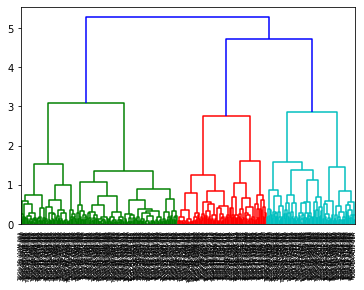

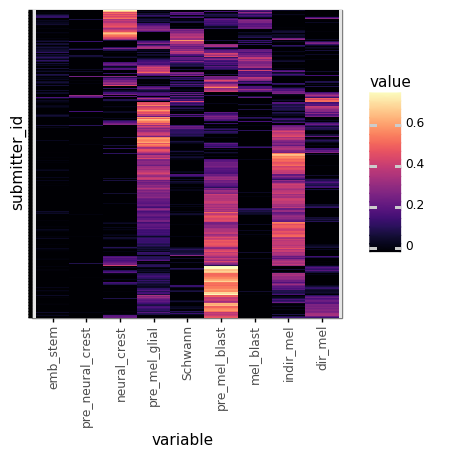

<ggplot: (-9223363246537428855)>


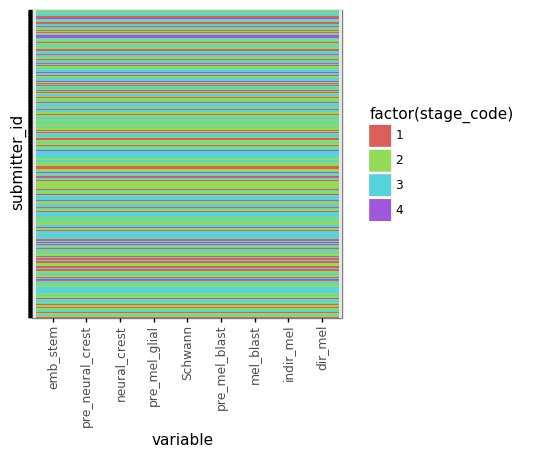

<ggplot: (8790297754460)>


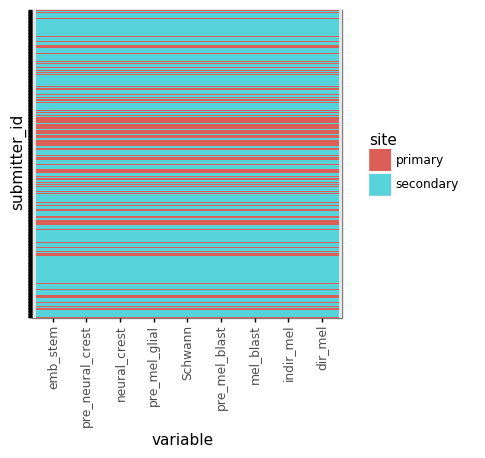

<ggplot: (-9223363246557913635)>


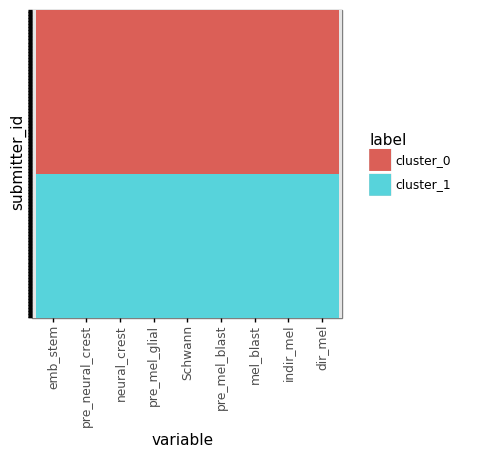

<ggplot: (8790279677462)>
computing...
cluster_1
cluster_0


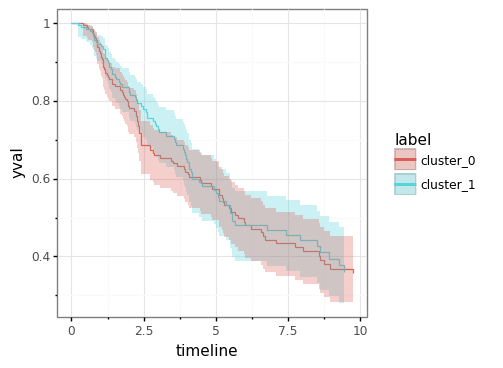

<ggplot: (-9223363246576050772)> 

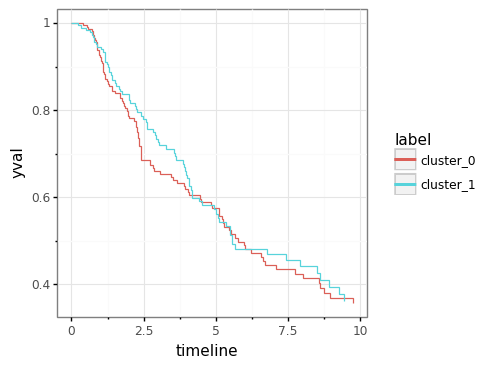

<ggplot: (8790307754742)>


In [22]:
print('computing...')

# ingest CIBERSORT table
ref_metric = 'OS'
scale_data = False
input_adata = adata_coi_noncyc
groupby = 'annotation'
heatmap_cmap = 'magma'
subtypes = [
                  'emb_stem', 
                                                  'pre_neural_crest',
                                                  'neural_crest',
                                                  'pre_mel_glial',
                                                  'Schwann',
                                                  'pre_mel_blast',
                                                  'mel_blast',
                                                  'indir_mel',
                                                  'dir_mel',
            ]
ciber_df = pd.read_csv('s3://darmanis-group/danle/dish_MEL/DL20191202_dish_cs.csv')
ciber_df = ciber_df.rename(columns = {'Input Sample':'submitter_id'})
ciber_df['bcr_patient_barcode'] = ['-'.join(x.split('-')[:3]) for x in ciber_df['submitter_id']]

# cs_vars = pd.read_csv('s3://darmanis-group/danle/MEL_project/DL20191023_sig_matrix_500.txt', sep = '\t')
# cs_vars_foll = cs_vars.NAME.tolist()

## gene clustering
n_clust = 2
timeline_threshold = 10
scale_data = False
input_table = pd.merge(ciber_df.loc[:,['bcr_patient_barcode','submitter_id']+subtypes],
                         tcga_meta_ordered.loc[:,['bcr_patient_barcode',
                                                  ref_metric,f'{ref_metric}.time',
                                                  'site','stage_code']],
                         'inner',
                         'bcr_patient_barcode')
input_table = input_table.dropna()
data = input_table.loc[:,subtypes].values
cluster_samples = input_table['submitter_id'].tolist()

# scale
if scale_data == True:
    data = StandardScaler().fit_transform(data)
    scaled_data = pd.DataFrame(data, columns=subtypes)
    
# clustering
Z = hierarchy.linkage(data, 'ward', optimal_ordering=True)
cutree = hierarchy.cut_tree(Z, n_clusters=[n_clust])
labels = cutree.flatten().tolist()
dn = hierarchy.dendrogram(Z, 
                          labels=cluster_samples
                         )
labels = [f'cluster_{x}' for x in labels]
input_table['label'] = labels
index_order = dn['ivl']

### melt
static_features = ['bcr_patient_barcode','submitter_id',
                  ref_metric,f'{ref_metric}.time',
                  'site','stage_code','label']
mel_meta_merge_melt = pd.melt(input_table.loc[:, static_features+subtypes], id_vars = static_features)
mel_meta_merge_melt['submitter_id'] = (mel_meta_merge_melt['submitter_id']
                                  .astype(str)
                                  .astype(CategoricalDtype(index_order, ordered = True))
                                 )
mel_meta_merge_melt['variable'] = (mel_meta_merge_melt['variable']
                               .astype(str)
                               .astype(CategoricalDtype(subtypes, ordered=True))
                              )
mel_meta_merge_melt = mel_meta_merge_melt[[x is not np.nan for x in mel_meta_merge_melt.variable]]
mel_meta_merge_melt = mel_meta_merge_melt.dropna()

plotnine.options.figure_size = (4,4)
plot = (ggplot(mel_meta_merge_melt)
        + theme_bw()
        + theme(axis_text_x = element_text(angle = 90),
                axis_text_y = element_blank()
               )
        + geom_tile(aes('variable','submitter_id',fill='value'))
        + scale_alpha_continuous(guide=False)
        + scale_fill_cmap(heatmap_cmap)
       )
print(plot)

plotnine.options.figure_size = (4,4)
feature_val = ['factor(stage_code)','site','label']
for x in feature_val:
    plot = (ggplot(mel_meta_merge_melt)
            + theme_bw()
            + theme(axis_text_x = element_text(angle = 90),
                    axis_text_y = element_blank()
                   )
            + geom_tile(aes('variable','submitter_id',fill=x))
           )
    print(plot)
    
#################################################################################
    
print('computing...')

# metrics
metric_label = ref_metric
metric = f'{metric_label}.time'

stage_corr = input_table.dropna()
stage_corr[metric_label] = stage_corr[metric_label].astype(int)
stage_corr[metric] = stage_corr[metric]/365

## create a kmf object
kmf = KaplanMeierFitter() 

## Fit the data into the model
kmf_df = pd.DataFrame()
kmf_ribbon = pd.DataFrame()
for x in set(stage_corr['label']):
    print(x)
    durations = stage_corr[stage_corr['label'] == x][metric].tolist()
    event_observed = stage_corr[stage_corr['label'] == x][metric_label].tolist()
    kmf.fit(durations, event_observed,label = 'yval')
    kmf_slice = pd.merge(kmf.survival_function_.reset_index(),
                  kmf.confidence_interval_.reset_index().rename(columns = {'index':'timeline'}),
                  'inner',
                  'timeline')
    kmf_slice['label'] = x
    kmf_df = kmf_df.append(kmf_slice)
    kmf_ribbon = kmf_df.append(kmf_slice[:-1])

# apply filters
kmf_df = kmf_df[kmf_df['timeline'] < timeline_threshold]


plot1 = (ggplot(kmf_df)
        + theme_bw()
        + geom_step(aes('timeline','yval',group='label',color='label'))
        + geom_rect(rect_converter(kmf_df, 'timeline', 'yval', 'yval_upper_0.95', 'yval_lower_0.95','label'),
                    aes(xmin='xmin', xmax='xmax', ymin='ymin', ymax='ymax', fill='label'), alpha=0.3)
       ) 
plot2 = (ggplot(kmf_df)
        + theme_bw()
        + geom_step(aes('timeline','yval',group='label',color='label'))
       )    

print(plot1, plot2)


# DEV: velocyto

In [ ]:
import loompy
import os
import scvelo as scv

In [ ]:
run = False

filedir = '/home/ubuntu/data/DL20190312_dish_mel/velocyto/'
files = [''.join([filedir,x]) for x in os.listdir(filedir) if (x.endswith('.loom') and x != 'merged.loom')]
for x in files:
    print(x)

filename = '/home/ubuntu/data/DL20190312_dish_mel/velocyto/merged.loom'
if run == True:
    loompy.combine(files,filename,"Accession")


In [ ]:
set(adata_all.obs.annotation)

In [ ]:
adata = scv.read(filename, cache=True)
adata_velo_merge = scv.utils.merge(adata_all[adata_all.obs.path == 'direct'], adata)
basis = 'umap'

scv.pp.filter_and_normalize(adata_velo_merge)
scv.pp.moments(adata_velo_merge)
scv.tl.velocity(adata_velo_merge)
scv.tl.velocity_graph(adata_velo_merge)
scv.tl.velocity_embedding(adata_velo_merge, basis=basis)


In [ ]:
component = '1,2'
scv.pl.velocity_embedding_grid(adata_velo_merge, 
                               basis=basis, 
                               figsize = (10,10),
                               components = component,
                               color = ['cycling_score'],
                               color_map = 'nipy_spectral',
                               ncols = 2
                                  )
